# Statistics on the Solar Jet Hunter catalogue
In this jupyter notebook you can look at the properties of the jet catalogue, includind reproducing figures presented in the project's paper (insert link here)

## Open the Solar Jet Hunter catalogue

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
file_path = 'exports/Jet_clusters_3.0_2.0_paperID.csv'
Jet_start_time = np.loadtxt(file_path, delimiter=',',
                          unpack=True, usecols=1, dtype='datetime64')

Jet_dur, Jet_Bx, std_Bx, Jet_By, std_By, Jet_Lon, Jet_Lat, Jet_H, upper_H, lower_H, Jet_W, std_W, stat_vel, stat_sigma, flags = np.loadtxt(
    file_path, delimiter=',', unpack=True, usecols=(3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17), dtype=float)
print(len(Jet_start_time))

883


## Plot histograms of the jets' parameters

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\SMusset\AppData\Local\Temp\ipykernel_25720\3961498178.py:5: SyntaxWarning: invalid escape sequence '\s'
  'Velocity ($km s^{-1}$)', '$\sigma_{IoU}$', 'Width (\'\')', 'Longitude ($degree$)', 'Latitude ($degree$)']


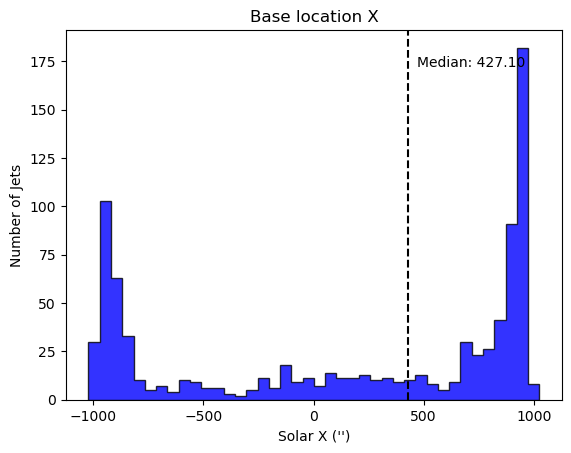

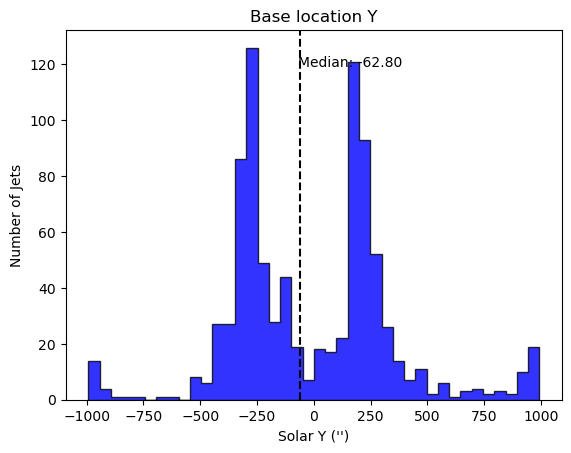

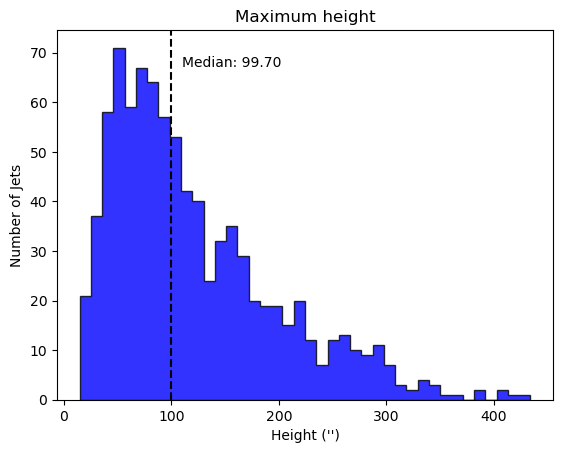

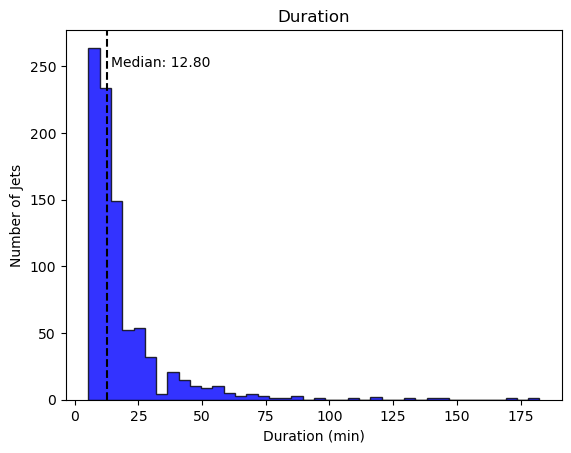

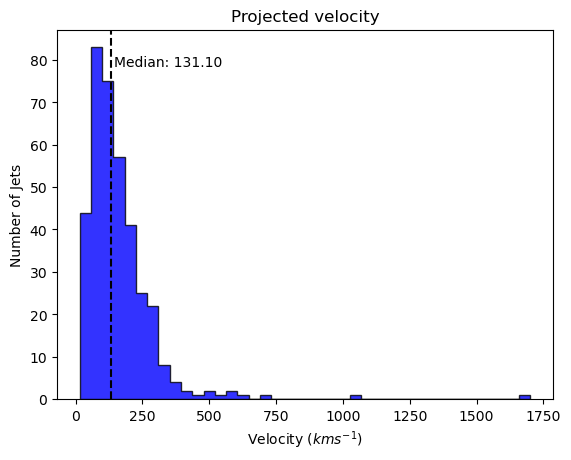

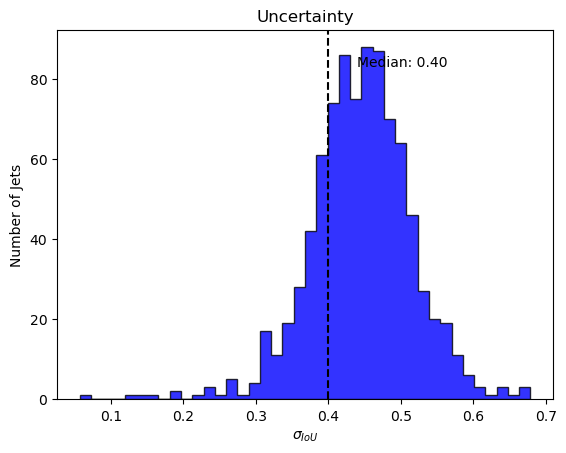

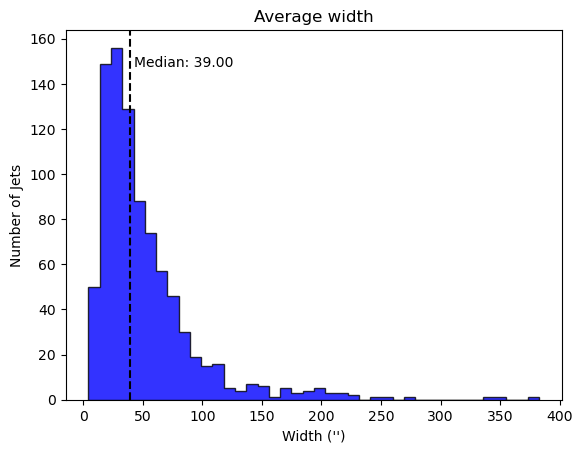

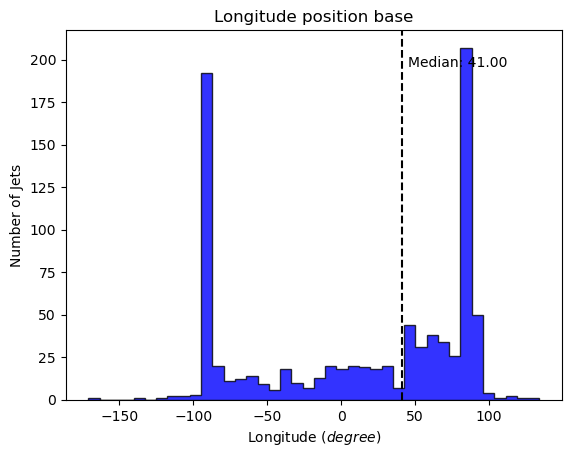

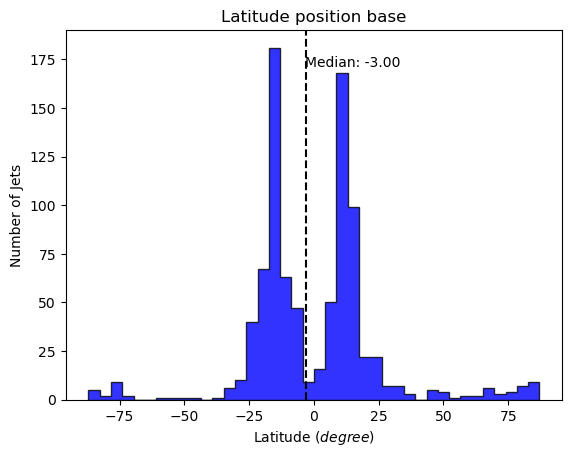

In [3]:
histo = [Jet_Bx, Jet_By, Jet_H, Jet_dur, stat_vel*725, stat_sigma, Jet_W, Jet_Lon, Jet_Lat]
title = ['Base location X', 'Base location Y', 'Maximum height', 'Duration', 'Projected velocity',
         'Uncertainty', 'Average width', 'Longitude position base', 'Latitude position base']
xlabel = ['Solar X (\'\')', 'Solar Y (\'\')', 'Height (\'\')', 'Duration (min)',
          'Velocity ($km s^{-1}$)', '$\sigma_{IoU}$', 'Width (\'\')', 'Longitude ($degree$)', 'Latitude ($degree$)']

for l in range(len(histo)):
    plt.ylabel('Number of Jets')
    plt.title(title[l])
    plt.hist(histo[l], histtype='stepfilled', color='blue', alpha=0.8,
             bins=40, ec="k")  # bins=30,color='red',alpha=0.8)
    plt.xlabel(xlabel[l])
    Med = np.round(np.nanmedian(histo[l]), 1)
    plt.axvline(Med, color='k', linestyle='dashed', linewidth=1.5)
    min_ylim, max_ylim = plt.ylim()
    plt.text(Med*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(Med))
    plt.show()

## Compare distribution in height of limb jets and disk jets

In [4]:
import scipy.stats as stats

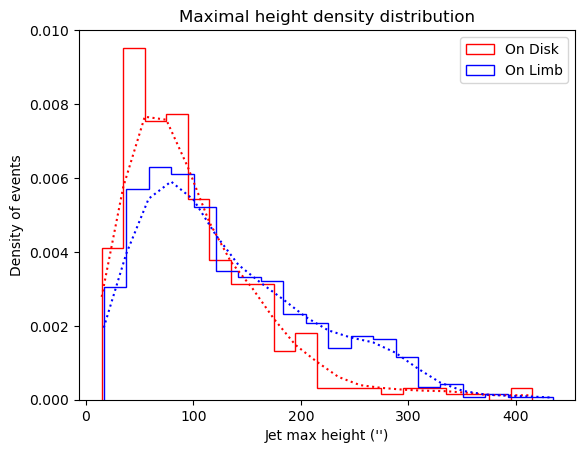

In [5]:
radial_distance = np.sqrt(Jet_Bx**2+Jet_By**2)
on_disk = radial_distance < 900
on_limb = radial_distance > 900
n_disk, x_disk, _ = plt.hist(Jet_H[on_disk], histtype='step',
                             bins=20, ec="red", label='On Disk', density=True)
n_limb, x_limb, _ = plt.hist(Jet_H[on_limb], histtype='step',
                             bins=20, ec="blue", label='On Limb', density=True)

density_disk = stats.gaussian_kde(Jet_H[on_disk])
density_limb = stats.gaussian_kde(Jet_H[on_limb])

plt.plot(x_disk, density_disk(x_disk), c='red', linestyle='dotted')
plt.plot(x_limb, density_limb(x_limb), c='blue', linestyle='dotted')

plt.title("Maximal height density distribution")
plt.legend()
plt.xlabel('Jet max height (\'\')')
plt.ylabel('Density of events')
plt.show()

## Plot all the positions of the bases of the jets on a blank map of the Sun

In [6]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from matplotlib import dates
import sunpy.map
from sunpy.coordinates import frames
from matplotlib import cm

C:\Users\SMusset\anaconda3\envs\sunpyenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


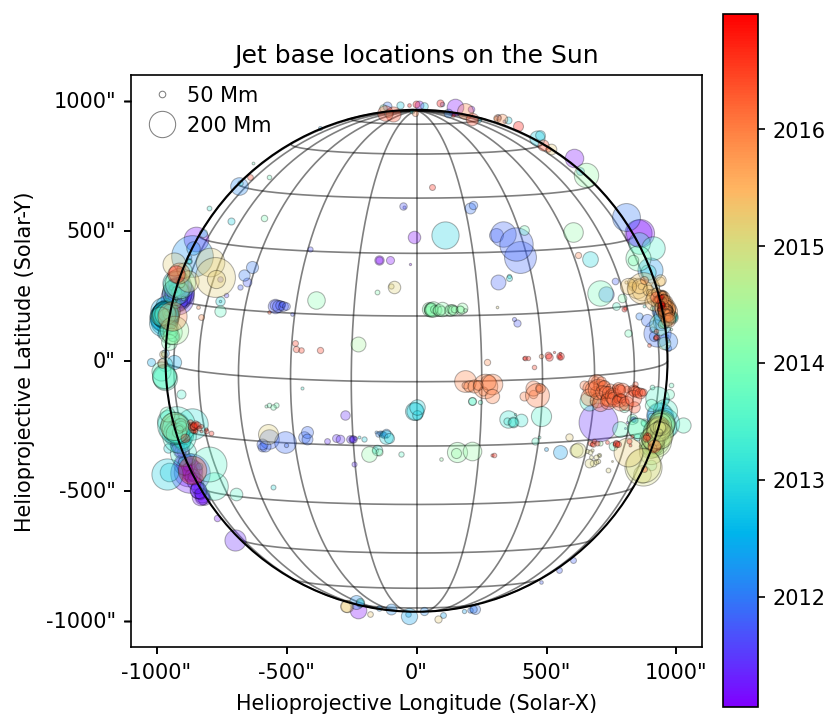

In [45]:
data = np.full((10, 10), np.nan)

# Define a reference coordinate and create a header using sunpy.map.make_fitswcs_header
skycoord = SkyCoord(0*u.arcsec, 0*u.arcsec, obstime='2013-10-28',
                    observer='earth', frame=frames.Helioprojective)

# Scale set to the following for solar limb to be in the field of view
header = sunpy.map.make_fitswcs_header(data, skycoord, scale=[220, 220]*u.arcsec/u.pixel)

# Use sunpy.map.Map to create the blank map
blank_map = sunpy.map.Map(data, header)

fig = plt.figure(figsize=(6, 6), dpi=150)
ax = plt.subplot(111,projection=blank_map)
blank_map.plot()
blank_map.draw_limb(color="k")
blank_map.draw_grid(color="k")

xc = Jet_Bx * u.arcsec
yc = Jet_By * u.arcsec
colours = cm.rainbow(np.linspace(0, 1, len((Jet_start_time))))
marker_sizes = Jet_H/np.max(Jet_H)*20

# to make legend circle size
marker_sizes_legend = np.array([50,200])/0.73/np.max(Jet_H)*20
marker_legend = ['50 Mm','200 Mm']

# Plot the coordinates of the base points per year
coords = SkyCoord(xc, yc, frame=blank_map.coordinate_frame)
epoch = [Jet_start_time[k].astype('datetime64[D]').astype(
    'int')/365 + 1970 for k in range(len(Jet_start_time))]

im = ax.scatter(Jet_Bx*0, Jet_By*0, c=dates.date2num(Jet_start_time),
                cmap='rainbow', s=0, marker='v')

for i in range(len(xc)):
    #ax.plot_coord(coords[i], 'o', markersize=5, c=colours[i], marker='v')
    ax.plot_coord(coords[i], 'o', markersize=marker_sizes[i], c=colours[i], alpha=0.3, markeredgewidth=0.5, markeredgecolor='black')

# create empty scatter plot to do legend
for size, label in zip(marker_sizes_legend, marker_legend):
   # ax.scatter([],[],s=size,label=label)
    ax.plot_coord([], 'o', markersize=size, label=label, c='white', markeredgewidth=0.5, markeredgecolor='black', alpha=0.5)

# Set title.
ax.set_title('Jet base locations on the Sun')
ax.legend(frameon=False, loc=2, borderaxespad=0.1, handletextpad=0.2)
# plt.colorbar()
cbar = fig.colorbar(im, ticks=dates.date2num(['2011', '2012', '2013', '2014', '2015', '2016', '2017']), ax=[ax], pad=0.03)

cbar.ax.set_yticklabels(['2011', '2012', '2013', '2014', '2015', '2016', '2017'])

plt.show()

In [35]:
print(np.min(Jet_H)*0.73,np.max(Jet_H)*0.73)

10.716404873295899 316.8632045438929
